# HW6 BOOSTING, STACKING, BLENDING

# Импорт библиотек

In [22]:
from IPython.display import clear_output
!pip install lightgbm==3.0
!pip install gdown
!pip install optuna
!pip install catboost
clear_output()

In [23]:
import catboost
import itertools
import imblearn
import lightgbm
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import scipy
import seaborn as sns
import sklearn
import sklearn.datasets
import xgboost

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV, cross_validate, cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score, balanced_accuracy_score, average_precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import matthews_corrcoef

# Задание 1. Feature selection и feature engineering

В этом задании используя датасет с [данными о здоровье плода](https://www.kaggle.com/andrewmvd/fetal-health-classification), сравните различные подходы к отбору признаков. Загрузим датасет:

In [24]:
data = pd.read_csv("fetal_health.csv")
data.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


Посмотрим на данные. Видно, что среди представленных признаков довольно много скоррелированных:

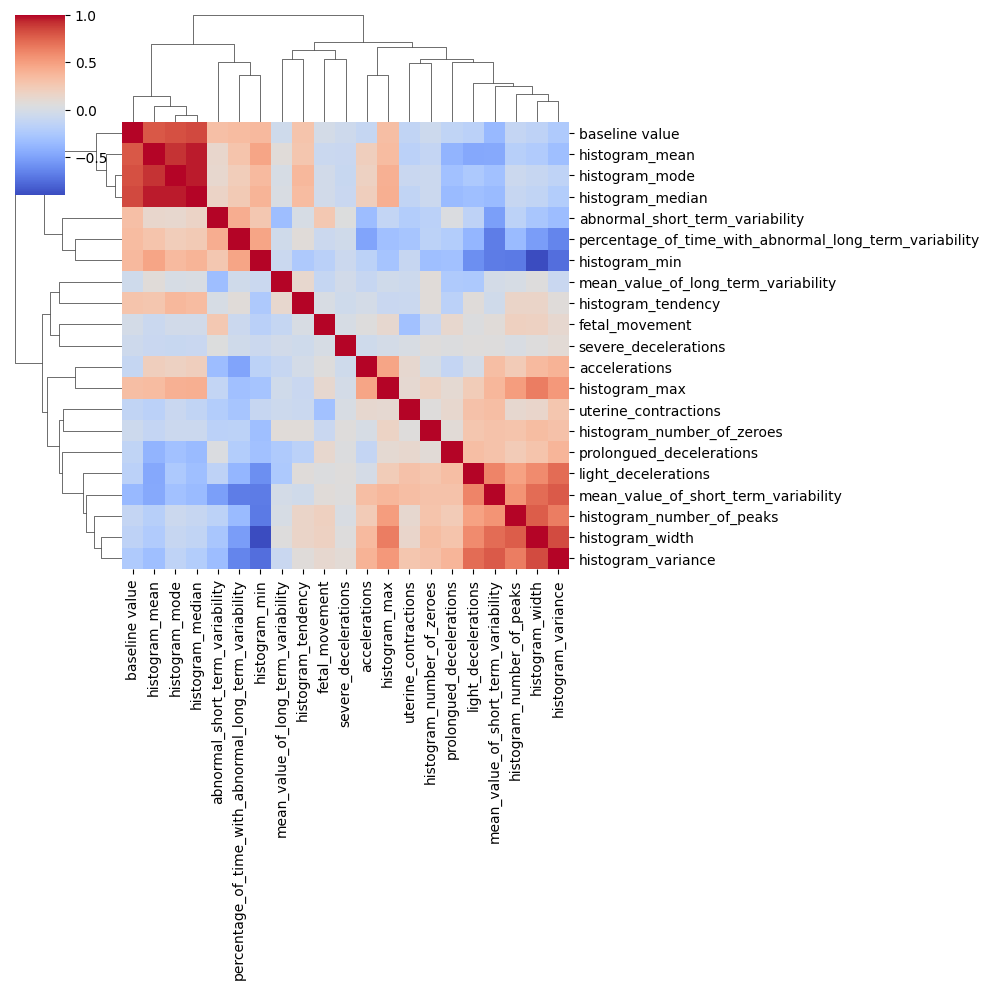

In [25]:
from sklearn.preprocessing import StandardScaler

x = data.drop('fetal_health', axis=1)
x = pd.DataFrame(StandardScaler().fit_transform(x), columns=x.columns, index= x.index)
y = data['fetal_health']

corr_matrix = x.corr(method='spearman')
res = sns.clustermap(corr_matrix, method='weighted', figsize=(10, 10), cmap='coolwarm')

Используя жадный отбор признаков, Add Del и PCA, отберите/сгенерируйте от 1 до 20 признаков и сравните на кросс-валидации accuracy для моделей RandomForestClassifier(n_estimators=50, random_state=42) из sklearn.ensemble, получающихся в процессе отбора/генерации признаков. Сравните полученные результаты с accuracy модели, обученной с использованием всех имеющихся признаков (на кросс-валидации с тем же количеством фолдов). Изобразите результаты в виде графика, опишите свои наблюдения.

In [26]:
x = np.array(x)
y = np.array(y)
rf_classifier = RandomForestClassifier(n_estimators=50, random_state=42)
all_features_accuracy = np.mean(cross_val_score(rf_classifier, x, y, cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring='accuracy'))
print(all_features_accuracy)

0.9416724661695663


In [27]:
from sklearn.feature_selection import SequentialFeatureSelector

# Жадный отбор признаков
sfs_accuracies = []
for i in range(1, x.shape[1]):
    sfs = SequentialFeatureSelector(rf_classifier, n_features_to_select=i, direction='forward', scoring='accuracy', cv=KFold(n_splits=5, shuffle=True, random_state=42))
    sfs.fit(x, y)
    selected_features = np.where(sfs.support_)[0]
    sfs_accuracy = np.mean(cross_val_score(rf_classifier, x[:, selected_features], y, cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring='accuracy'))
    sfs_accuracies.append(sfs_accuracy)

In [28]:
from mlxtend.feature_selection import SequentialFeatureSelector

# Add Del
sfsb_accuracies = []
for i in range(1, x.shape[1]):
    sfsb = SequentialFeatureSelector(rf_classifier, k_features=i, forward=True, floating=True, scoring='accuracy', cv=KFold(n_splits=5, shuffle=True, random_state=42))
    sfsb.fit(x, y)
    selected_features = np.array(list(sfsb.k_feature_idx_))
    sfsb_accuracy = np.mean(cross_val_score(rf_classifier, x[:, selected_features], y, cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring='accuracy'))
    sfsb_accuracies.append(sfsb_accuracy)

In [29]:
from sklearn.decomposition import PCA

# PCA
pca_accuracies = []
for i in range(1, x.shape[1]):
    pca = PCA(n_components=i)
    X_pca = pca.fit_transform(x)
    pca_accuracy = np.mean(cross_val_score(rf_classifier, X_pca, y, cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring='accuracy'))
    pca_accuracies.append(pca_accuracy)

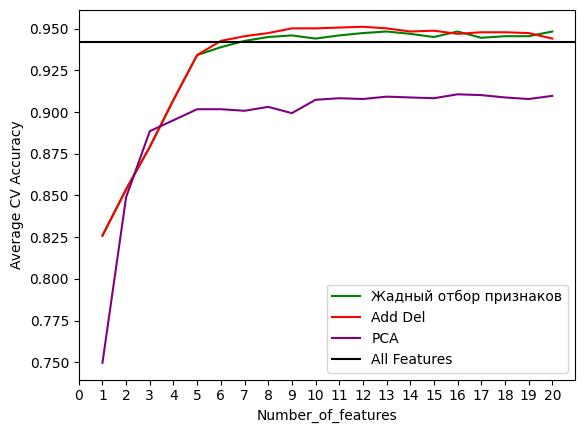

In [30]:
num_features = np.arange(1, x.shape[1])

plt.plot(num_features, sfs_accuracies, label='Жадный отбор признаков', color='green')
plt.plot(num_features, sfsb_accuracies, label='Add Del', color='red')
plt.plot(num_features, pca_accuracies, label='PCA', color='purple')

plt.axhline(y=all_features_accuracy, color='black', label='All Features')

plt.xlabel('Number_of_features')
plt.ylabel('Average CV Accuracy')
plt.xticks(np.arange(0, x.shape[1], 1.0))
plt.legend()
plt.show()

_Вывод:_

Accuracy модели обученной с использованием всех имеющихся признаков (на кросс-валидации с тем же количеством фолдов) = 0.9416724661695663

PCA справился хуже всех и показал accuracy < 0.94

Add Del и жадный отбор показали accuracy > 0.94 при Number_of_features > 8

Лучше всех сработал Add Del

## Формат результата

* Accuracy модели, обученной с использованием всех имеющихся признаков >0.9.

* Пример графика для одного из пунктов задания:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/Exercises/EX04/result_3_task_ex04_fix.png" width="300">

# Задание 2. Ансамблевое обучение *

В данной задаче вам нужно диагностировать сердечное заболевание у людей по [медицинским показателям](https://www.kaggle.com/datasets/cherngs/heart-disease-cleveland-uci).

In [31]:
heart_dataset = pd.read_csv("heart.csv")
heart_dataset

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [32]:
from sklearn.preprocessing import LabelEncoder

name = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
categorial_data = pd.DataFrame()
for i in name:
  categorial_data[i] = heart_dataset[i]
le = LabelEncoder()
X = pd.DataFrame()
for i in name:
  le.fit(categorial_data[i])
  X[i] = le.transform(categorial_data[i])
data = heart_dataset
for i in name:
  data[i] = X[i]
data

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,1,3,110,264,0,1,132,0,1.2,1,1
914,68,1,0,144,193,1,1,141,0,3.4,1,1
915,57,1,0,130,131,0,1,115,1,1.2,1,1
916,57,0,1,130,236,0,0,174,0,0.0,1,1


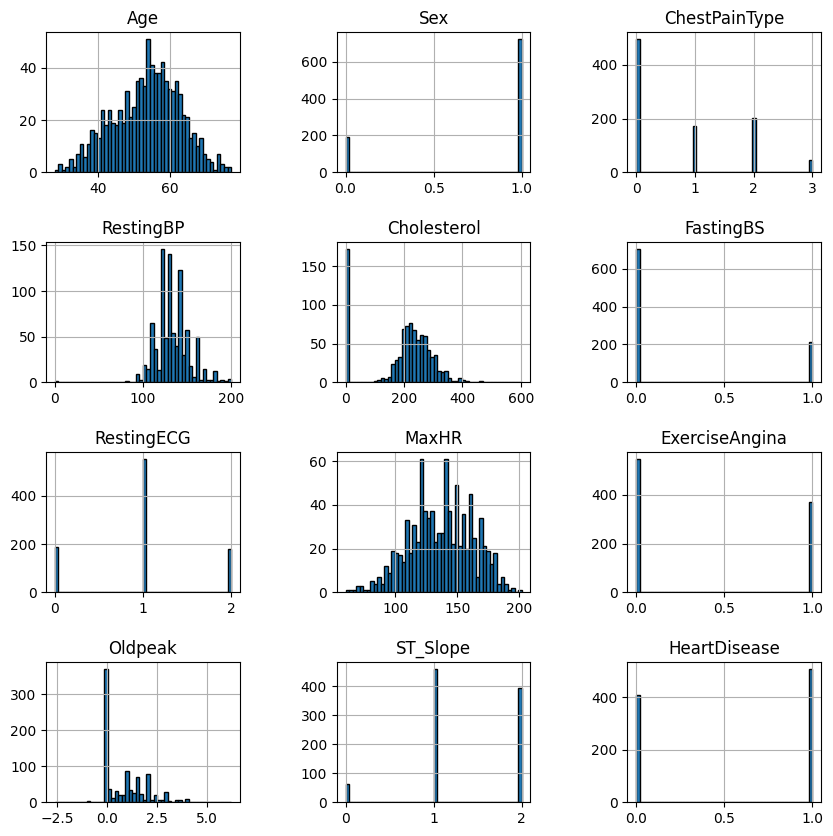

In [33]:
data.hist(figsize=(10, 10), bins=50, edgecolor="black")
plt.subplots_adjust(hspace=0.5, wspace=0.5)

In [34]:
x = data.drop('HeartDisease', axis=1)
y = data['HeartDisease']
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
sc = StandardScaler()
sc.fit(x_train)
x_train, x_test = sc.transform(x_train), sc.transform(x_test)

Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`.

In [35]:
rng = np.random.RandomState(42)

dt = DecisionTreeClassifier(random_state=rng, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=rng)
etc = ExtraTreesClassifier(random_state=rng)
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
svc_lin = SVC(kernel='linear', probability=True, random_state=rng)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=rng)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=42)
lgbm = lightgbm.LGBMClassifier(random_state=42)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=42)
xgb = xgboost.XGBClassifier(random_state=42)
xgb_rf = xgboost.XGBRFClassifier(random_state=42)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

voting_hard = VotingClassifier(estimators=[('dt', dt), ('rf', rf), ('cat', cat), ('etc', etc),
                                           ('knn', knn), ('svc_lin', svc_lin), ('svc_rbf', svc_rbf),
                                           ('xgb', xgb), ('lgbm', lgbm), ('xgb_rf', xgb_rf),
                                           ('lgbm_rf', lgbm_rf), ('lr', lr), ('nb', nb)],
                               voting='hard')
voting_soft = VotingClassifier(estimators=[('dt', dt), ('rf', rf), ('cat', cat), ('etc', etc),
                                           ('knn', knn), ('svc_lin', svc_lin), ('svc_rbf', svc_rbf),
                                           ('xgb', xgb), ('lgbm', lgbm), ('xgb_rf', xgb_rf),
                                           ('lgbm_rf', lgbm_rf), ('lr', lr), ('nb', nb)],
                               voting='soft')

for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]:
    scores = cross_val_score(model, x_train, y_train, cv=KFold(n_splits=3, shuffle=True, random_state=rng), scoring='f1')
    print(f'{model.__class__.__name__}: {scores.mean()}')

DecisionTreeClassifier: 0.8454800646098614
RandomForestClassifier: 0.8658984341585229
CatBoostClassifier: 0.8762994320008574
ExtraTreesClassifier: 0.8774092138595982
KNeighborsClassifier: 0.8437063751085079
SVC: 0.8685398563952781
SVC: 0.8661305269769115
XGBClassifier: 0.844993280122741
LGBMClassifier: 0.8563928462544116
XGBRFClassifier: 0.8613324721240865
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignor

Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не сккоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тренировочном наборе, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Можете модифицировать функцию `base_model_pair_correlation` из предыдущего задания.

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


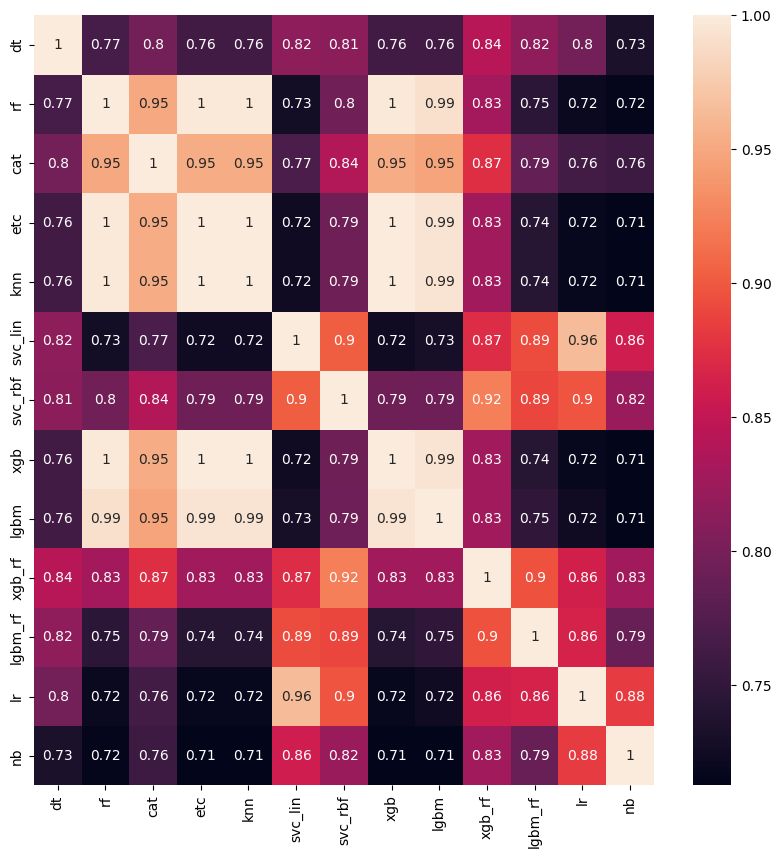

In [36]:
bmp = []
for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb]:
    model.fit(x_train, y_train)
    bmp.append(model.predict(x_train))

paircor = np.corrcoef(bmp)
df = pd.DataFrame(data=paircor, index=["dt", "rf", "cat", "etc", "knn", "svc_lin", "svc_rbf", "xgb", "lgbm", "xgb_rf", "lgbm_rf", "lr", "nb"], columns=["dt", "rf", "cat", "etc", "knn", "svc_lin", "svc_rbf", "xgb", "lgbm", "xgb_rf", "lgbm_rf", "lr", "nb"])
fig, heat = plt.subplots(figsize=(10, 10))
fig = sns.heatmap(df, annot=True)

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


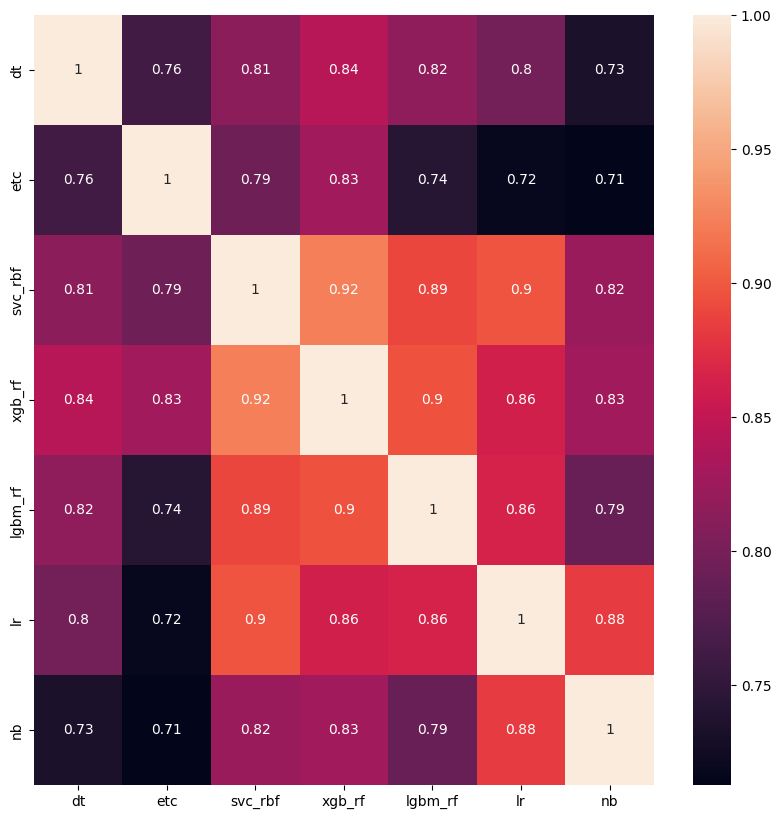

In [37]:
bmp = []
for model in [dt, etc, svc_rbf, xgb_rf, lgbm_rf, lr, nb]: # убрал rf, cat, knn, svc_lin, xgb, lgbm
    model.fit(x_train, y_train)
    bmp.append(model.predict(x_train))
paircor = np.corrcoef(bmp)
df = pd.DataFrame(data=paircor, index=["dt", "etc", "svc_rbf", "xgb_rf", "lgbm_rf", "lr", "nb"], columns=["dt", "etc", "svc_rbf", "xgb_rf", "lgbm_rf", "lr", "nb"])
fig, heat = plt.subplots(figsize=(10, 10))
fig = sns.heatmap(df, annot=True)

Создайте новый ансамбль, на исправленном наборе моделей и оцените его качество с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`.

In [42]:
voting_hard_2 = VotingClassifier(estimators=[('dt', dt), ('etc', etc),
                                           ('svc_rbf', svc_rbf),
                                           ('xgb_rf', xgb_rf),
                                           ('lgbm_rf', lgbm_rf), ('lr', lr), ('nb', nb)],
                               voting='hard')

voting_soft_2 = VotingClassifier(estimators=[('dt', dt), ('etc', etc),
                                           ('svc_rbf', svc_rbf),
                                           ('xgb_rf', xgb_rf),
                                           ('lgbm_rf', lgbm_rf), ('lr', lr), ('nb', nb)],
                               voting='soft')

for model in [voting_hard_2, voting_soft_2]:
    scores = cross_val_score(model, x_train, y_train, cv=KFold(n_splits=3, shuffle=True, random_state=rng), scoring='f1')
    print(f'{model.__class__.__name__}: {scores.mean()}')

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
VotingClassifier: 0.8785408991439313
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0

Обучите все получившиеся модели на тренировочном наборе и испытайте их качество на тестовом наборе. Получилось ли у улучшенных версий ансамблевого классификатора превзойти базовые модели, входящие в него и свои предыдущие версии?

In [47]:
from sklearn.metrics import f1_score

for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb]:
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    print(f'{model.__class__.__name__}: {f1_score(y_test, pred)}')

voting_hard.fit(x_train, y_train)
pred = voting_hard.predict(x_test)
print('voting_hard')
print(f'{voting_hard.__class__.__name__}: {f1_score(y_test, pred)}')

voting_soft.fit(x_train, y_train)
pred = voting_soft.predict(x_test)
print('voting_soft')
print(f'{voting_soft.__class__.__name__}: {f1_score(y_test, pred)}')

voting_hard_2.fit(x_train, y_train)
pred = voting_hard_2.predict(x_test)
print('voting_hard_2')
print(f'{voting_hard_2.__class__.__name__}: {f1_score(y_test, pred)}')

voting_soft_2.fit(x_train, y_train)
pred = voting_soft_2.predict(x_test)
print('voting_soft_2')
print(f'{voting_soft_2.__class__.__name__}: {f1_score(y_test, pred)}')

DecisionTreeClassifier: 0.888888888888889
RandomForestClassifier: 0.8957528957528957
CatBoostClassifier: 0.9
ExtraTreesClassifier: 0.9069767441860465
KNeighborsClassifier: 0.8784313725490196
SVC: 0.8715953307392996
SVC: 0.8854961832061069
XGBClassifier: 0.890625
LGBMClassifier: 0.889763779527559
XGBRFClassifier: 0.9083969465648855
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
LGBMClassifier: 0.8669201520912547
LogisticRegression: 0.875
GaussianNB: 0.8759689922480621
voting_hard
VotingClassifier: 0.9042145593869731
voting_soft
VotingClassifier: 0.9118773946360152
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
voting_hard_2
VotingClassif

Какие ансамбли работают лучше? Всегда ли больше моделей значит лучше?

Ансамбли сработали лучше чем большая часть базовых моделей

Voting_hard и Voting_soft работают примерно одинаково

После удаления из ансамбля моделей, чьи предсказания сильнее коррелируют с остальными, на train метрика f1_score выросла, а на test немного уменьшилась

## Формат результата

Получить значения качества для ансамблей и моделей.